In [45]:
import xarray as xr
from awips.dataaccess import DataAccessLayer
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta, timezone
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from sklearn.metrics import mean_squared_error
import cartopy.feature as cfeature
import xesmf as xe
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from pyproj import Proj
from scipy.interpolate import griddata

In [46]:
initial_time = datetime.today().replace(day=5).astimezone(timezone.utc)

window_end = initial_time + timedelta(hours=5)

# Initialize DataAccessLayer to access EDEX server
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")

In [47]:

# HRRR dataset URL from THREDDS
hrrr_catalog_url = "https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/TwoD"

# Fetch the most recent HRRR dataset
cat = TDSCatalog(hrrr_catalog_url)
dataset = list(cat.datasets.values())[0]

# Access the HRRR subset using NCSS
ncss = NCSS(dataset.access_urls['NetcdfSubset'])

# Define the query for temperature data
query = ncss.query().lonlat_box(-130, -60, 20, 55).variables('Temperature_height_above_ground').time(initial_time)

# Retrieve the data
hrrr_data = ncss.get_data(query)


In [48]:


geospatial_lon_min = hrrr_data.geospatial_lon_min
geospatial_lon_max = hrrr_data.geospatial_lon_max
geospatial_lat_min = hrrr_data.geospatial_lat_min
geospatial_lat_max = hrrr_data.geospatial_lat_max

extent = [
    geospatial_lon_min,
    geospatial_lon_max,
    geospatial_lat_min,
    geospatial_lat_max
]

lamb_proj = list(hrrr_data.variables.values())[-1]

latitude_of_projection_origin = lamb_proj.latitude_of_projection_origin
longitude_of_central_meridian = lamb_proj.longitude_of_central_meridian
standard_parallel = lamb_proj.standard_parallel

lambcoordref = ccrs.LambertConformal(
    central_longitude=longitude_of_central_meridian,
    central_latitude=latitude_of_projection_origin,
    standard_parallels=[standard_parallel]
    )

lambert_conformal = Proj(
    proj="lcc", 
    lat_1=standard_parallel,   # First standard parallel
    lat_0=latitude_of_projection_origin,   # Central latitude (origin)
    lon_0=longitude_of_central_meridian, # Central longitude (origin)
)

# Extract temperature and coordinates from the HRRR dataset
# Convert kilometers to meters (PyProj expects meters)

temps = hrrr_data.variables['Temperature_height_above_ground'][:]
lons = hrrr_data.variables['x'][:] * 1000  # Convert to meters
lats = hrrr_data.variables['y'][:] * 1000  # Convert to meters




In [ ]:



def fetch_metar_data(start, end):
    # Set up request for METAR data
    request = DataAccessLayer.newDataRequest()
    request.setDatatype("obs")
    request.setParameters("temperature")
    request.addIdentifier("reportType", "METAR")

    # Set the desired time for the request
    #request.setTimeRange(time)

    window = TimeRange(start,end)

    # Retrieve the METAR observations from the EDEX server
    #DataAccessLayer.getAvailableTimes(request)
    metar_data = DataAccessLayer.getGeometryData(request,window)


    lons, lats, temps = [], [], []
    
    # Extract latitude, longitude, and temperature from the observations
    for data in metar_data:
        if data.getNumber("temperature") is not None:
            lons.append(data.getGeometry().x)
            lats.append(data.getGeometry().y)
            temps.append(data.getNumber("temperature"))
    
    return lons, lats, temps

# Fetch METAR data for the current time (use UTC)

metar_lons, metar_lats, metar_temps = fetch_metar_data(initial_time,window_end)


In [50]:


x_grid, y_grid = np.meshgrid(lons.data, lats.data)

lon_grid, lat_grid = lambert_conformal(x_grid,y_grid, inverse=True)

x = lon_grid.flatten()
y = lat_grid.flatten()
values = temps.data[0][0][0].flatten()
points = np.array([x, y]).T

# Define a regular lat/lon grid (PlateCarree) to interpolate to
target_lons = np.linspace(x.min(), x.max(), lons.data.shape[0])  # Regular longitude grid
target_lats = np.linspace(y.min(), y.max(), lats.data.shape[0])     # Regular latitude grid

target_x_grid, target_y_grid = np.meshgrid(target_lons, target_lats)

temperature_grid = griddata(points, values, (target_x_grid, target_y_grid), method='nearest')

# Step 5: Create an xarray Dataset with the new grid
ds = xr.Dataset(
    data_vars={
        'temperature': (['latitude', 'longitude'], temperature_grid)
    },
    coords={
        'longitude': (['longitude'], target_lons),
        'latitude': (['latitude'], target_lats)
    }
)

temperature_grid


array([[295.7930603, 295.9180603, 295.9180603, ..., 302.5430603,
        302.5430603, 302.5430603],
       [295.6055603, 295.7930603, 295.7930603, ..., 302.5430603,
        302.5430603, 302.5430603],
       [295.6680603, 295.6055603, 295.6055603, ..., 302.4805603,
        302.4805603, 302.4805603],
       ...,
       [284.0430603, 284.1680603, 284.2305603, ..., 283.2930603,
        284.2305603, 286.6680603],
       [284.1680603, 284.2305603, 284.1680603, ..., 283.2930603,
        284.2305603, 286.6680603],
       [284.1680603, 284.2305603, 284.1680603, ..., 284.6055603,
        283.2930603, 284.2305603]])

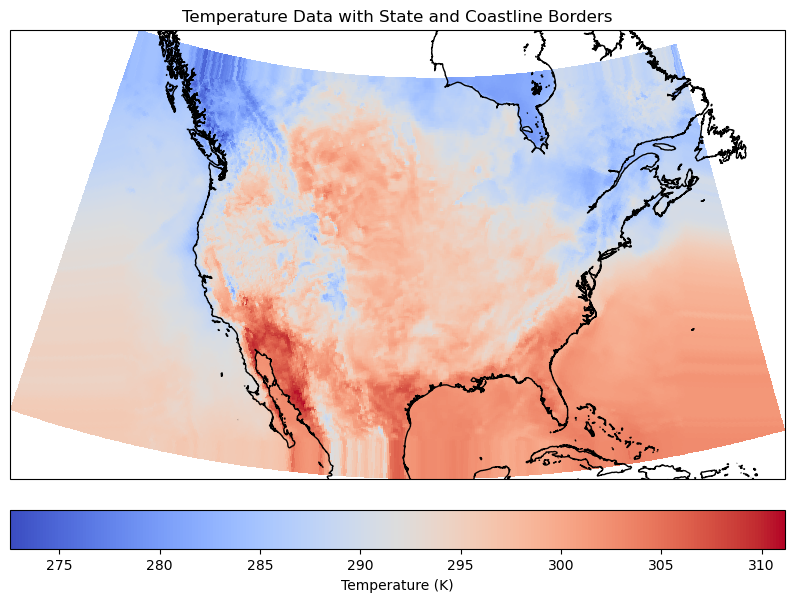

In [57]:
# Step 6: Plot with Cartopy (Lambert Conformal projection)
plt.figure(figsize=(10, 8))
ax = plt.axes(projection = lambcoordref)

# Plot the temperature data using pcolormesh, with lat/lon
temp_plot = ax.pcolormesh(target_lons, target_lats, temperature_grid,
                           transform = ccrs.PlateCarree(), cmap='coolwarm')

# Add coastlines and states
ax.coastlines(resolution='10m')  # Coastlines at 10m resolution
#ax.add_feature(cfeature.BORDERS.with_scale('10m'))  # Country borders
#ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')  # US state borders

# Add colorbar
plt.colorbar(temp_plot, label="Temperature (K)", orientation="horizontal", pad=0.05)

# Set the extent (longitude and latitude range)

#ax.set_extent(extent)
# Title and display
plt.title("Temperature Data with State and Coastline Borders")
plt.show()

NameError: name 'lon_da' is not defined

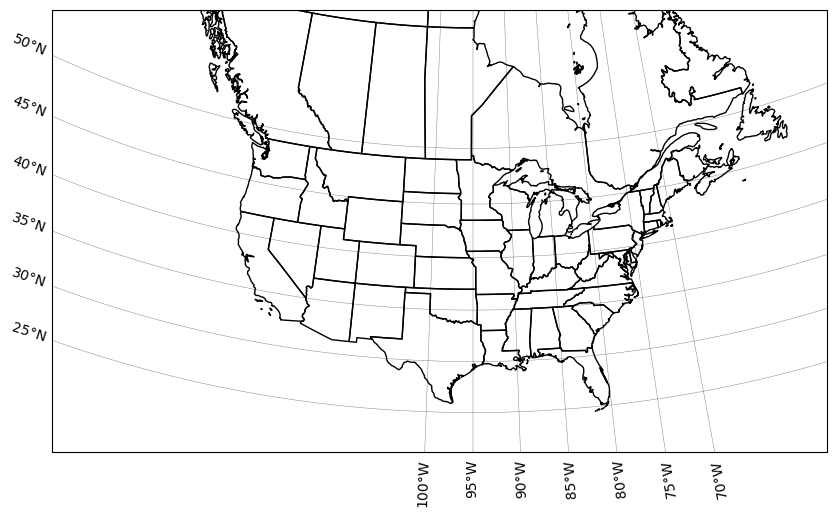

In [55]:
# Plotting the data on a map using Cartopy
def plot_data(metar_lons, metar_lats, metar_temps, hrrr_lons, hrrr_lats, hrrr_temps):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.LambertConformal())
    
    # Set extent to cover the continental US
    ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())
    
    # Add coastlines, borders, and state lines
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)

    # Plot HRRR temperature data (assumed to be on a grid)
    sc1 = ax.pcolormesh(hrrr_lons, hrrr_lats, hrrr_temps[0], cmap='coolwarm', transform=ccrs.PlateCarree(), alpha=0.5)
    plt.colorbar(sc1, ax=ax, orientation='vertical', label='HRRR Temperature (K)')
    
    # Plot METAR temperature observations
    sc2 = ax.scatter(metar_lons, metar_lats, c=metar_temps, cmap='coolwarm', s=50, edgecolor='k', transform=ccrs.PlateCarree())
    plt.colorbar(sc2, ax=ax, orientation='vertical', label='METAR Temperature (°C)')

    plt.title(f'METAR and HRRR Temperature Observations at {initial_time} UTC')
    plt.show()

# Plot both datasets together
plot_data(metar_lons, metar_lats, metar_temps, hrrr_lons, hrrr_lats, hrrr_temps[0][0])
